# Pairs Trading Analysis.

In this notebook, we test that the Data library is working as proposed. When we call get pricing on a list of symbols or a singleton symbol a Pandas Dataframe or Series should be returned respectively.

In [7]:
import time
import datetime
import random
import json

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
from scipy.stats import norm

import scraper
import retrieve_data_2
get_pricing = retrieve_data_2.basic_pipeline.get_pricing

### S&P500
We use the next few cells to import helpful data and define functions that will be useful for analysis stocks in the S&P500

In [ ]:
with open('industry_to_stocks') as f:
    industry_to_stocks = json.load(f)

with open('sector_to_stocks') as f:
    sector_to_stocks = json.load(f)
    
with open('sp500') as f:
     sp500 = json.load(f)

with open('date_joined') as f:
    symbol_to_date_joined = json.load(f)

In [19]:
industry_to_stocks

{'Industrial Conglomerates': ['MMM', 'GE', 'HON', 'ROP'],
 'Health Care Equipment': ['ABT',
  'ABMD',
  'A',
  'BAX',
  'BDX',
  'BSX',
  'DHR',
  'DXCM',
  'EW',
  'HOLX',
  'IDXX',
  'ISRG',
  'MDT',
  'PKI',
  'RMD',
  'STE',
  'SYK',
  'TFX',
  'VAR',
  'ZBH'],
 'Pharmaceuticals': ['ABBV', 'JNJ', 'LLY', 'MRK', 'MYL', 'PRGO', 'PFE'],
 'IT Consulting & Other Services': ['ACN', 'CTSH', 'DXC', 'IT', 'IBM', 'LDOS'],
 'Interactive Home Entertainment': ['ATVI', 'EA', 'TTWO'],
 'Application Software': ['ADBE',
  'ANSS',
  'ADSK',
  'CDNS',
  'CTXS',
  'INTU',
  'NLOK',
  'ORCL',
  'PAYC',
  'CRM',
  'SNPS'],
 'Semiconductors': ['AMD',
  'ADI',
  'AVGO',
  'INTC',
  'MXIM',
  'MCHP',
  'MU',
  'NVDA',
  'QRVO',
  'QCOM',
  'SWKS',
  'TXN',
  'XLNX'],
 'Automotive Retail': ['AAP'],
 'Independent Power Producers & Energy Traders': ['AES', 'NRG'],
 'Life & Health Insurance': ['AFL', 'GL', 'MET', 'PFG', 'PRU', 'UNM'],
 'Industrial Gases': ['APD', 'LIN'],
 'Internet Services & Infrastructure': [

If this is out-of-date, uncomment and use the following:

In [8]:
# sp500 = scraper.sp500
# symbol_to_date_joined = scraper.symbol_to_date_joined
# sector_to_stocks = scraper.sector_to_stocks
# industry_to_stocks = scraper.industry_to_stocks

# # You can use the following code to store these dictionaries as JSON files for future use and import them using
# # the code in the cell above.

# with open('sector_to_stocks', 'w') as f:
#     json.dump(sector_to_stocks, f)

# with open('industry_to_stocks', 'w') as f:
#     json.dump(industry_to_stocks, f)

# with open('sp500', 'w') as f:
#     json.dump(sp500, f)

# with open('date_joined', 'w') as f:
#     json.dump(symbol_to_date_joined, f)

We can use `relevant_symbols` to remove symbols from a list that weren't in the S&P500 before a certain date. This helps to avoid look ahead bias (Equities are likely to rise in price before being added to the index). 

In [ ]:
def joined_before_date(symbol, start_date):
    """Checks when a stock was added to the S&P500."""
    join_date = symbol_to_date_joined[symbol]
    if join_date == '':
        return False
    return time.strptime(join_date, "%Y-%m-%d") <= time.strptime(start_date, "%Y-%m-%d")

def relevant_symbols(symbols, start_date):
    """Removes S&P500 symbols that weren't in the S&P500 before `start_date`."""
    new_symbols = [symbol for symbol in symbols if joined_before_date(symbol, start_date)]
    return new_symbols

### Framework

I have tried my hand at creating infrastructure to log trades. I have created classes for trades and pairs of trades to aide analysis and calculations.

In [49]:
trade_to_multiplier = {"Short": -1, "Long": 1}

class PairTrade():
    id_counter = 0
    
    def __init__(self, shorted, longed, close_info=None, close_condition = None):
        self.shorted = shorted  # The short trade
        self.longed = longed  # The long trade
        self.close_info = close_info  # Any information that will be require to close the trade
        self.close_condition = close_condition  # A function called to determine when to close the trade
        self.id = PairTrade.id_counter
        PairTrade.id_counter += 1
#         self.is_open = True
    
    @classmethod
    def reset_ids(cls):
        # Todo: Maybe delete other instances to make sure IDs remain unique
        cls.id_counter = 0
    
    def is_open(self):
        """Checks whether or not a trade is open."""
        return self.shorted.is_open and self.longed.is_open
    
    def current_profit(current_price_shorted, current_price_longed):
        """Returns the realised profit of a closed trade or the current profit otherwise."""
        if self.is_open():
            return self.shorted.current_profit(current_price_shorted) + self.longed.current_profit(current_price_longed)
        return self.profit
        
    def close_trade(self, X_now, Y_now, close_date=None):
        """This closes out both positions based on current prices and updates the PairTrade status."""
        if self.close_info['direction'] == 1:
            long_close = X_now
            short_close = Y_now
        else:  # Todo: check that this condition is comprehensive
            long_close = Y_now
            short_close = X_now
        self.shorted.close_trade(short_close, close_date)
        self.longed.close_trade(long_close, close_date)
        self.short_close = short_close
        self.long_close = long_close 
        self.profit = self.shorted.profit + self.longed.profit
        self.close_date = close_date
        
    def __str__(self):
        string = "PAIR trade " + str(self.id) + "\n[First trade]\n" + str(self.shorted) + "\n[Second trade]\n" + \
        str(self.longed) +"\n"
        if not self.is_open():
            string += "Total Profit: " + str(self.profit) + "\n"
        return string
        
        
        
        
class Trade():
    id_counter = 0
    def __init__(self, symbol, direction, entry_price, size, entry_date=None):   # Todo: create automatic entry_date 
        
        # Todo: Change the structure so that short positions just have negative sizes
        self.direction = direction
        self.multiplier = trade_to_multiplier[self.direction]
        
        self.security = symbol
        self.entry_price = entry_price
        self.size = size
        self.is_open = True
        self.entry_date = entry_date  # Todo: Add method to find current date or time
        self.id = Trade.id_counter
        Trade.id_counter += 1
        
    @classmethod
    def reset_ids(cls):
        cls.id_counter = 0
        
    def current_profit(self, current_price):
        if self.is_open:
            return self.multiplier*(self.close - self.current)*self.size
        return self.profit
    
    def close_trade(self, close_price, close_date=None):
        self.close_price = close_price
        self.profit = self.multiplier*(self.close_price - self.entry_price)*self.size
        self.is_open = False
        self.close_date = close_date  # Todo: Add method to find current data or time
        
    def __str__(self):
        string = "ID: "+ str(self.id) +"\n" + str(self.direction) + " " +str(self.security) +"\nEntry date: " +str(self.entry_date) + "\nSize:" + str(self.size)\
        +"\nEntry at "+ str(self.entry_price) +"\nStatus: "
        if self.is_open:
            string += "Open\n"
            return string
        string += "Closed\nClose Price: " + str(self.close_price) + "\nClose Date: " + str(self.close_date) + "\nProfit: " + str(self.profit) +"\n"
        return string
    




### The Strategy

We can now implement a rolling mean reversion strategy on a pair of secuirities. The strategy works by testing for cointegrability between the linearly scaled pair over a window. If a pair is cointegrable, then this implies stationarity. Stationarity means that the relationship the linearly scaled X security and the Y security is not changing of over time. We then model the difference between the two as a normal random variable (or the process over time as a brownian motion) so that we enter trades in one of two cases: 

1. If the difference gets too high, we bet on it going back down by shorting Y and buying X 

2. If the difference gets too low, we bet on it going back up by shorting X and buying Y

We determine "too high" and "too low" by examining the the cdf of the difference at our current time with respect to our normal random variable model.

A trade is closed out when the difference returns to 0.

The fact that we are short on one security whilst long on another, gives us a certain amount of market neutrality. However, at the moment the rules governing the volume of trades in this strategy has not been fine tuned so the strategy may not be as market neutral as it could be.

In [50]:
def rolling_signals(X, Y, window=35):
    """Generates pair trade signals for each time point based on data from a rolling window."""
    if len(X) != len(Y) or len(X) <= window:
        raise Exception("The series must have the same length and be greater than 0")
        
    X_symbol = X.name
    Y_symbol = Y.name
    in_trade = 0  # Flag to retain what our current trading status is
    trades = []
    
    for i in range(window, len(X)):
        X_now = X.iloc[i]
        Y_now = Y.iloc[i]
        date = X.index[i]
        
        # Todo: Add stop loss and take profit
        
        if in_trade != 0 and len(trades)>0: 
            # Checking if we have an open trade. If so,
            # we look to see if we should close it the most recent trade.
            trade = trades[-1]
            if trade.close_condition(X_now, Y_now, trade.close_info):
                trade.close_trade(X_now, Y_now, date)
                in_trade = 0
                
        elif in_trade == 0:
            X_window = X.iloc[i-window:i]
            Y_window = Y.iloc[i-window:i]
            
            # Tests if the pair shows cointegrability over the past window.
            # X_coeff is a number if so, otherwise the is `False`
            X_coeff = pair_test(X_window, Y_window, sig_level=.05)
            
            if X_coeff != False:
                # We scale X. This should make the mean of the `diffs` series 0 but we store
                # calculate that anyway
                diffs = Y_window - X_coeff*X_window
                diffs.name = 'diffs'
                mean = diffs.mean()
                sd = diffs.std()
                
                # Information needed by the close_condition method
                close_info = {'mean': mean, 'sd': sd, 'X_coeff': X_coeff}
                
                
                # Checking if the current prices are extreme enough to open a trade
                cdf_value = norm.cdf(Y_now - X_coeff*X_now, loc=mean, scale=sd)
                if cdf_value >= 0.95:
                    short = Trade(Y.name, "Short", Y_now, 1, entry_date=date)
                    long = Trade(X.name, "Long", X_now, X_coeff, entry_date=date)
                    close_info['direction'] = 1
                    
                    pair_trade = PairTrade(short, long, close_info, close_condition)
                    trades.append(pair_trade)
                    
                    in_trade = 1
                elif cdf_value <= 0.05:
                    short = Trade(X.name, "Short", X_now, X_coeff, entry_date=date)
                    long = Trade(Y.name, "Long", Y_now, 1, entry_date=date)
                    close_info['direction'] = -1
                    
                    pair_trade = PairTrade(short, long, close_info, close_condition)
                    trades.append(pair_trade)
                    in_trade = -1
    return trades

def coeff(X, Y):
    """Linearly regresses X onto Y and returns the coefficient for the X values."""
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    results = model.fit()
    return results.params
                
def close_condition(X_now, Y_now, close_info):
    """Returns whether to close pair trade for this strategy or not based on the condition given 
    when trade was entered.
    """
    mean = close_info['mean']
    sd = close_info['sd']
    X_coeff = close_info['X_coeff']
    cdf_value = norm.cdf(Y_now - X_coeff*X_now, loc=mean, scale=sd)
    
    if close_info['direction'] == 1 and cdf_value <= 0.5:
        return True
    if close_info['direction'] == -1 and cdf_value >= 0.5:
        return True
    return False
    
    
def pair_test(X, Y, sig_level=0.05):
    """Tests if a pair passes a cointegrability test at given significance level."""
    X_coeff = coeff(X, Y)[1]
    _, p_value, _ =  coint(X_coeff*X, Y)
    if p_value <= sig_level:
        return X_coeff
    return False
    

### Testing the strategy and trade logging framework.

To test the strategy we shall look at data from CVS and LH as they are in the same industry and so are more likely to show cointegrability. It is important that you don't just test many random stocks together until you find cointegrability otherwise you will more likely act on false positives. This is because our hypothesis test will give a false positive for cointegrability of a pair 5% of the time even when they actually aren't.

In [51]:
data = get_pricing(["PEP", "COKE"], start_date="2016-01-01", end_date="2018-12-31")

From db: PEP
From db: COKE


In [52]:
X_train, Y_train = data.PEP, data.COKE
rolled_signals = rolling_signals(X_train, Y_train)

And we can take a look at each of these trades. We shall look at the first and list three.

In [53]:
for pos in rolled_signals:
    if not pos.is_open():
        print(pos)

PAIR trade 0
[First trade]
ID: 0
Short PEP
Entry date: 2016-05-11 00:00:00
Size:1.248612597288389
Entry at 93.2055
Status: Closed
Close Price: 92.2951
Close Date: 2016-11-11 00:00:00
Profit: 1.136736908571344

[Second trade]
ID: 1
Long COKE
Entry date: 2016-05-11 00:00:00
Size:1
Entry at 143.2856
Status: Closed
Close Price: 164.738
Close Date: 2016-11-11 00:00:00
Profit: 21.45240000000001

Total Profit: 22.589136908571355

PAIR trade 1
[First trade]
ID: 2
Short PEP
Entry date: 2016-12-01 00:00:00
Size:-4.644951050659921
Entry at 89.2401
Status: Closed
Close Price: 92.6464
Close Date: 2016-12-07 00:00:00
Profit: 15.822096763862898

[Second trade]
ID: 3
Long COKE
Entry date: 2016-12-01 00:00:00
Size:1
Entry at 156.4067
Status: Closed
Close Price: 159.3772
Close Date: 2016-12-07 00:00:00
Profit: 2.970499999999987

Total Profit: 18.792596763862885

PAIR trade 2
[First trade]
ID: 4
Short COKE
Entry date: 2016-12-09 00:00:00
Size:1
Entry at 164.4134
Status: Closed
Close Price: 131.9198
Close

We use these helper functions to further analyse the strategy.

In [39]:
def total_profit(trades, include_open=False):
    """Finds the total realised profit from a list of trades."""
    total = 0
    for pos in trades:
        if not pos.is_open():
            total += pos.profit
    return total

def number_of_trades(trades):
    """Finds number of trades closed trades in a list of trades."""
    count = 0
    for pos in trades:
        if not pos.is_open():
            count += 1
    return count

In [54]:
total_profit(rolled_signals)

96.40300998748096

Therefore we see that this strategy generate a profit of $96 on the Pepsi and Coke pair between these dates. The function `plot_on_prices` allows us to see when the trades were mades on the joint price chart.

In [55]:
def plot_on_prices(X, Y, positions):
    """Plots buy and sell orders from a list of executed trades on their price charts."""
    sell_X = X*np.nan
    sell_Y = X*np.nan
    buy_X = X*np.nan
    buy_Y = X*np.nan
    
    for pos in positions:
        if pos.shorted.security == X.name:
            sell_X[pos.shorted.entry_date] = pos.shorted.entry_price
            buy_Y[pos.longed.entry_date] = pos.longed.entry_price
            if not pos.is_open():
                buy_X[pos.shorted.close_date] = pos.shorted.close_price
                sell_Y[pos.longed.close_date] = pos.longed.close_price
        else:
            buy_X[pos.longed.entry_date] = pos.longed.entry_price
            sell_Y[pos.shorted.entry_date] = pos.shorted.entry_price
            if not pos.is_open():
                sell_X[pos.longed.close_date] = pos.longed.close_price
                buy_Y[pos.shorted.close_date] = pos.shorted.close_price
    
    plt.figure(figsize=(12.6, 4.6))        
    plt.plot(X, label=X.name) #label="Difference between " + Y_symbol + " and scaled " + X_symbol)
    plt.plot(Y, label=Y.name)
    plt.scatter(X.index, buy_X, label="Buy "+ X.name, marker='^', color="green")
    plt.scatter(X.index, buy_Y, label="Buy "+Y.name , marker='^', color="green")
    plt.scatter(X.index, sell_X, label="Sell "+X.name, marker='v', color="red")
    plt.scatter(X.index, sell_Y, label="Sell "+Y.name, marker='v', color="red")
    plt.title("Buy and Sell signals between the pairs "+X.name+ " and "+Y.name)
    plt.xlabel(str(X.index[0])+" - "+str(X.index[-1]))
    plt.legend()
    plt.show()

C:\Users\bumuk\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


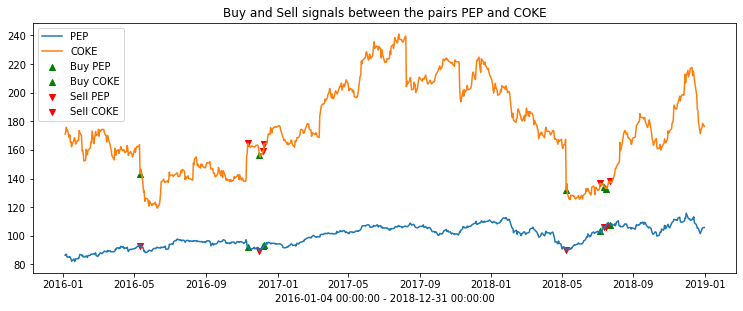

In [56]:
plot_on_prices(X_train, Y_train, rolled_signals)

### Exercising the strategy on more pairs

Using `generate_trades` allows us to test the strategy on each pair in a collection of stocks.

In [57]:
def generate_trades(price_data, window=35, rolling_signals=rolling_signals):
    """Runs strategy, using `rolling_signals`, on every combination of security pairs in the price_data dataframe
    and generates_trades."""
    positions_list = [] 
    for i in range(len(symbols)-1):
        X_symbol = symbols[i]
        X = price_data[X_symbol]
        for j in range(i+1, len(symbols)):
            Y_symbol = symbols[j]
            Y = price_data[Y_symbol]
            positions_list.append((rolling_signals(X, Y, window),X.name, Y.name))
    return positions_list

We pick a specific industry in the S&P500 so that the pairs are more likely to be cointegrable and then run the function.

In [67]:
start_date = "2007-01-01"
end_date = "2008-12-31"
symbols = industry_to_stocks['Household Products']
price_data = get_pricing(symbols, start_date, end_date)

From db: CHD
From db: CLX
From db: CL
From db: KMB


In [68]:
trades = generate_trades(price_data)

In [69]:
print("Strategy run between ", start_date, " and ", end_date, "\n")
for collection in trades:
    X_name = collection[1]
    Y_name = collection[2]
    print("Pair: " + X_name + " and " + Y_name)
    print("Number of closed trades: ", number_of_trades(collection[0]))
    print("Total Profit: ", total_profit(collection[0]))
    print()

Strategy run between  2007-01-01  and  2008-12-31 

Pair: CHD and CLX
Number of closed trades:  3
Total Profit:  5.694714036333325

Pair: CHD and CL
Number of closed trades:  4
Total Profit:  5.688936578844855

Pair: CHD and KMB
Number of closed trades:  6
Total Profit:  12.132056699714814

Pair: CLX and CL
Number of closed trades:  3
Total Profit:  3.993854252926252

Pair: CLX and KMB
Number of closed trades:  7
Total Profit:  10.261432412014923

Pair: CL and KMB
Number of closed trades:  3
Total Profit:  3.9355612707133405

